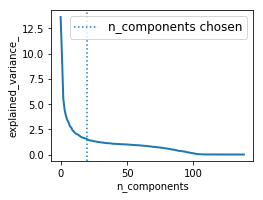

Suggest use 20 components


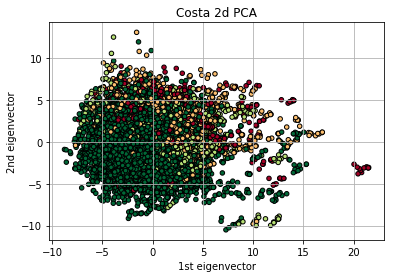

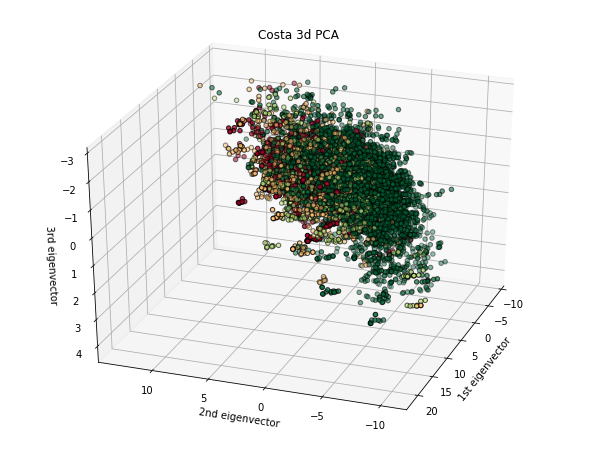

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 2 columns):
Id         9557 non-null object
idhogar    9557 non-null object
dtypes: object(2)
memory usage: 149.4+ KB


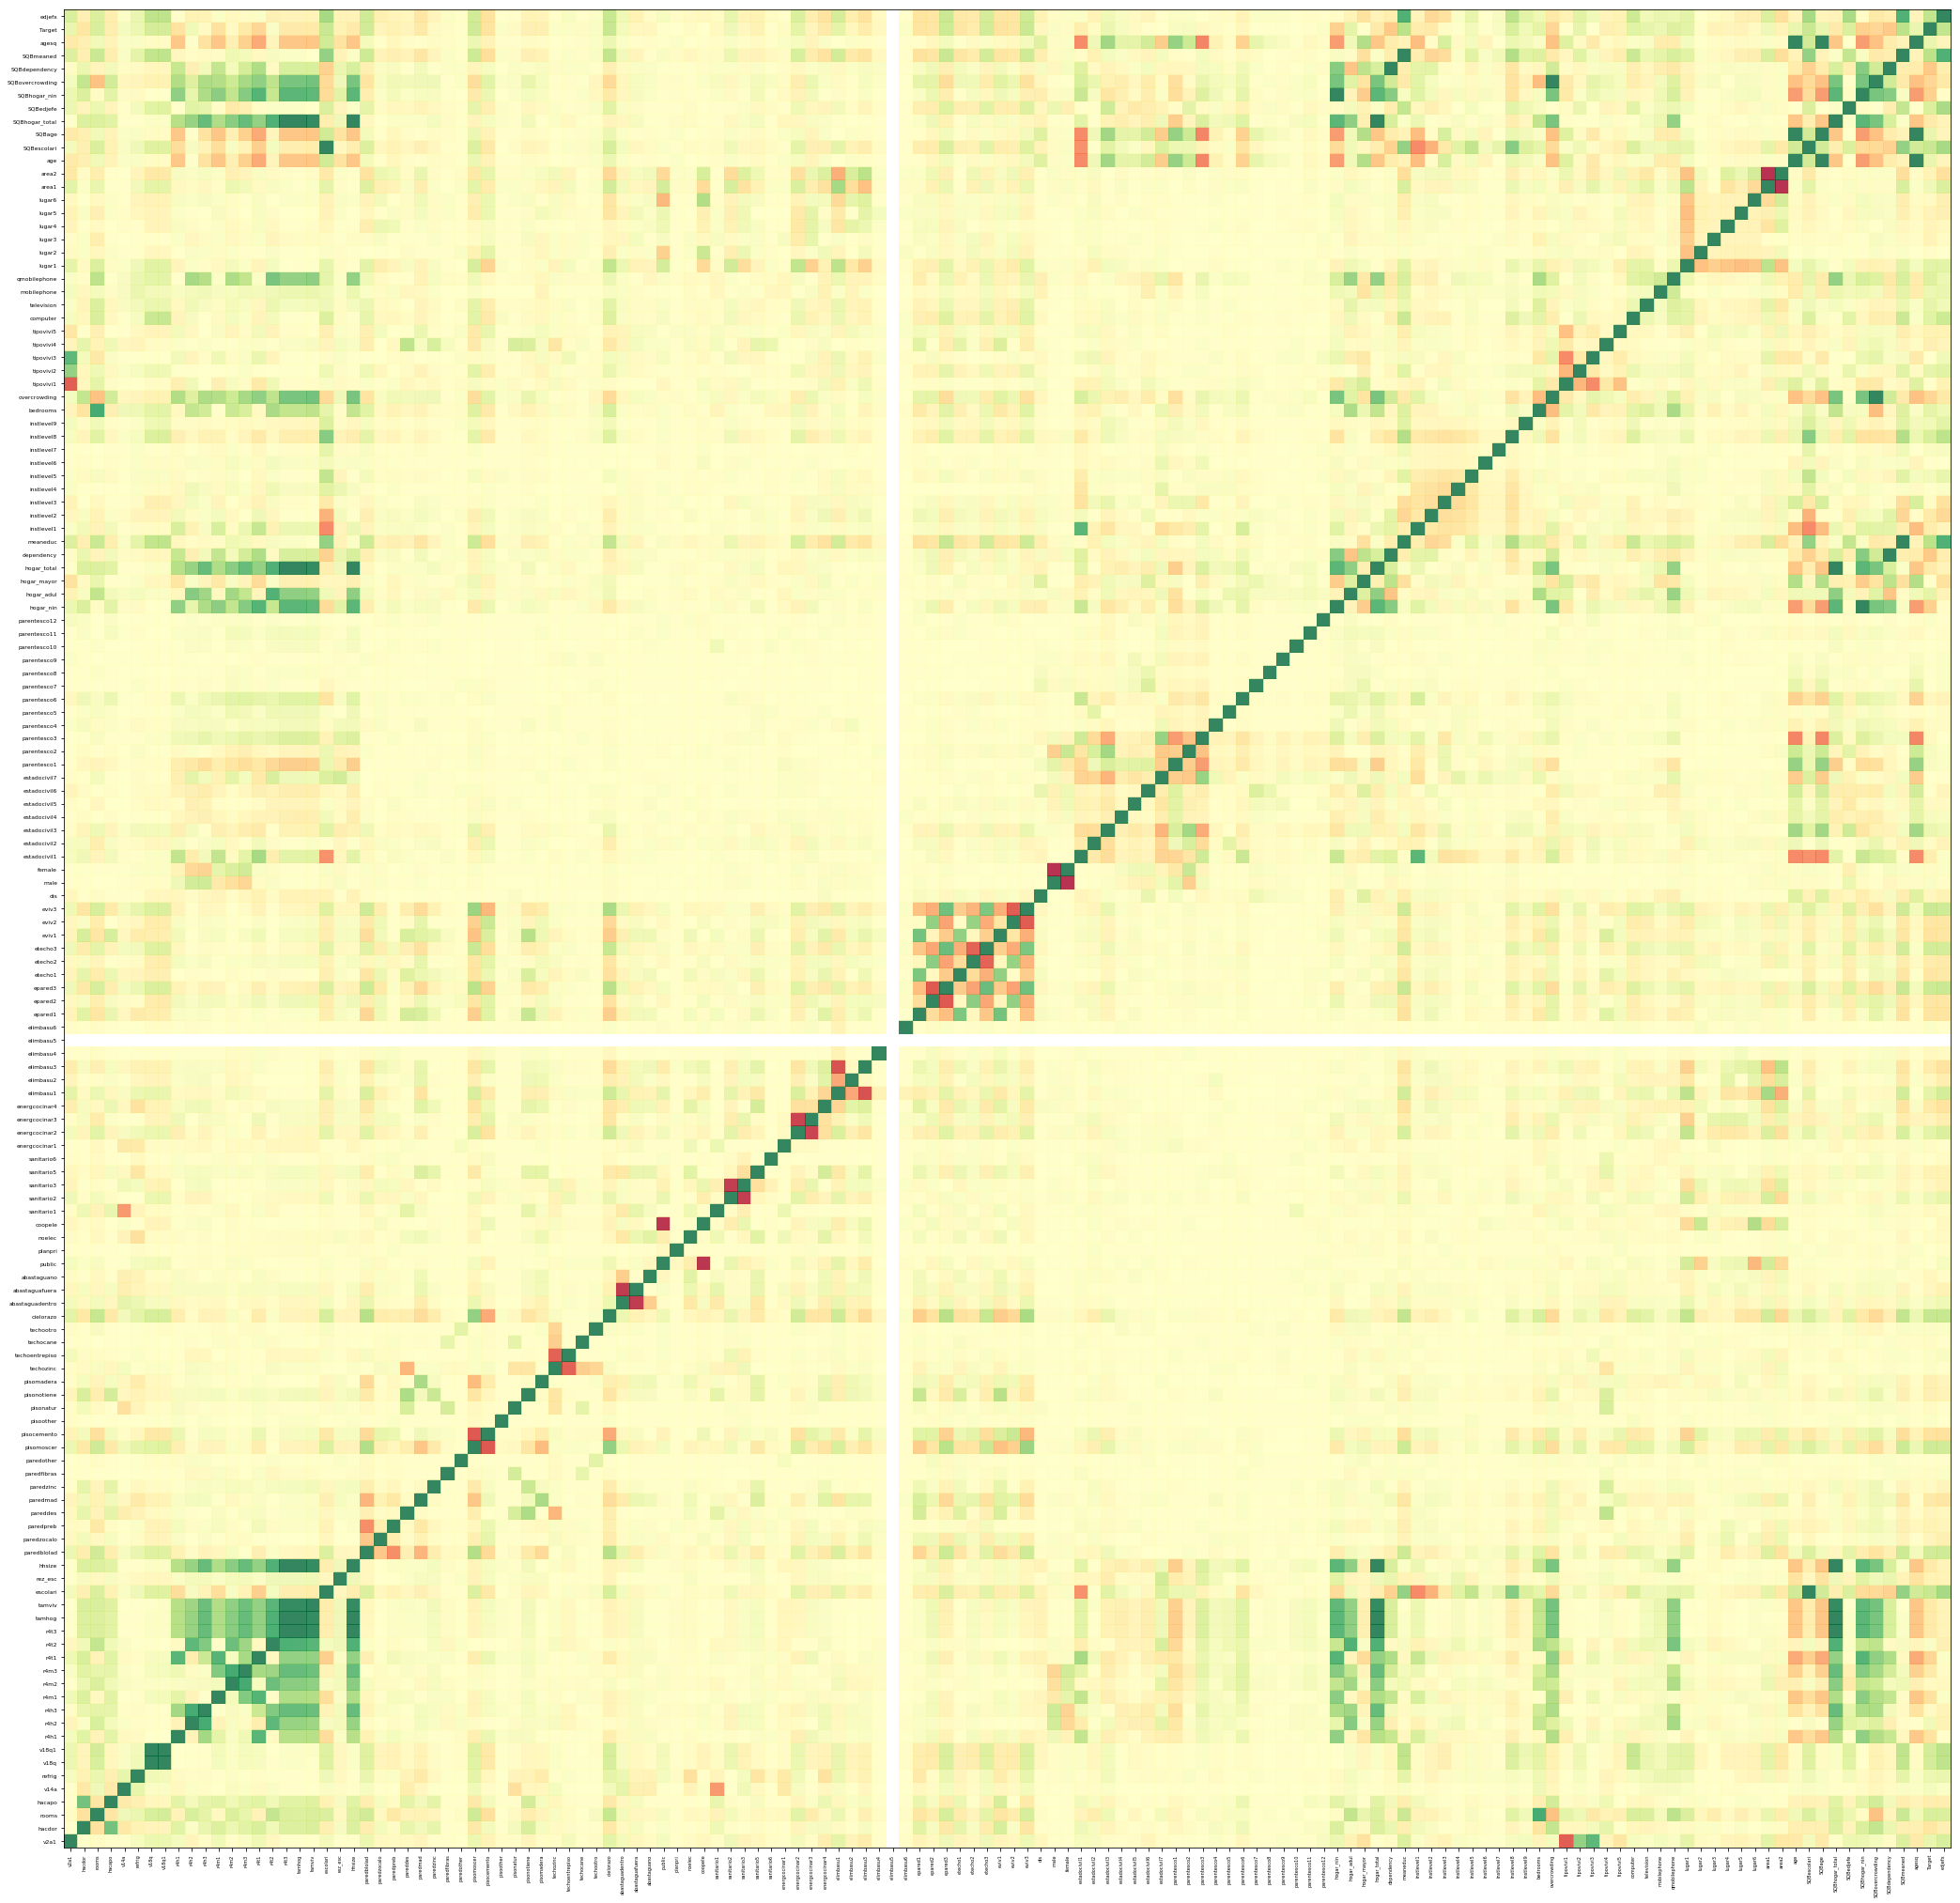

In [11]:
# code to describe and explore datasets
# developed using the kaggle costarica poverty data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from math import log
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

def get_n_components(xds,yds):
    # Code source: Gaël Varoquaux
    # Modified for documentation by Jaques Grobler
    # License: BSD 3 clause
    # from documentation for sklearn


    import numpy as np
    import matplotlib.pyplot as plt


    logistic = linear_model.LogisticRegression()

    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

    X_digits = xds
    y_digits = yds 

    # Plot the PCA spectrum
    pca.fit(X_digits)

    plt.figure(1, figsize=(4, 3))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(pca.explained_variance_, linewidth=2)
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_')

    # Prediction
    n_components = [20, 40, 64]
    Cs = np.logspace(-4, 4, 3)

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    estimator = GridSearchCV(pipe,
                             dict(pca__n_components=n_components,
                                  logistic__C=Cs))
    estimator.fit(X_digits, y_digits)

    plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    plt.legend(prop=dict(size=12))
    plt.show()
    print('Suggest use %d components' % estimator.best_estimator_.named_steps['pca'].n_components)

def doheat(ds):
    # simple heatmap of pairwise correlations for all (numeric) variables
    # tricky to get labels on cor matrix
    dsc = ds.corr(method='spearman')
    fig, ax = plt.subplots()
    cm = plt.cm.RdYlGn # plt.cm.RdBu  plt.cm.Blues
    ax.pcolor(dsc, cmap=cm, alpha=0.8)
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    nlab = len(ds.columns)
    tix = [float(x)+0.5 for x in range(0,nlab)]
    #print('###ymin,ymax,xmin,xmax,n=',ymin,ymax,xmin,xmax,nlab)
    ax.set_yticks(tix,minor=False)
    ax.set_xticks(tix,minor=False)

    ax.set_xticklabels(ds.columns, minor=False,fontsize=5)
    ax.set_yticklabels(ds.columns, minor=False,fontsize=6)

    # rotate the
    plt.xticks(rotation=90)

    ax.grid(False)
    # Format
    fig = plt.gcf()
    fig.set_size_inches(36, 36)
    fig.savefig("costaheat.png")
    plt.show


def dohists(ds):
    num_bins = 50
    for c in list(ds.columns.values):
        x = ds[c].values
        ctab = ds[c].value_counts()
        if ctab.size > 2:
            mx = min(x)
            # the histogram of the data
            if mx > 0:
                xp = [log(X) for X in x]
            else:
                xp = [log(X+1) for X in x]
            fig, ax = plt.subplots()
            n, bins, patches = ax.hist(xp, num_bins, density=1)
            ax.set_xlabel(c)
            ax.set_ylabel('Probability density')
            ax.set_title(r'Histogram of %s' % c)

            # Tweak spacing to prevent clipping of ylabel
            fig.tight_layout()
            ax.grid()
            plt.show()
            #fig.savefig("test.png")
        else:
            print('%s has a binary distribution:\n%s' % (c,ctab))


def pca3d(data,labels,mytitle):
    fig = plt.figure(figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=160)
    pca = PCA(n_components=3)
    
    X_reduced = pca.fit_transform(sdata)

    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], data[:, 2], c=labels, 
               cmap=plt.cm.RdYlGn, edgecolor='k', s=20) 
    ax.set(xlabel="1st eigenvector", ylabel="2nd eigenvector",zlabel="3rd eigenvector",
           title=mytitle)
    ax.grid()

    #fig.savefig("test.png")
    plt.show()

def pca2d(data,labels,mytitle):

    pca = PCA(n_components=2)    
    X_reduced = pca.fit_transform(data)

    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1],c=labels, cmap=plt.cm.RdYlGn, 
               edgecolor='k',s=20)

    ax.set(xlabel="1st eigenvector", ylabel="2nd eigenvector",
           title=mytitle)
    ax.grid()

    #fig.savefig("test.png")
    plt.show()
            
def data_cleaning_costa(data):
    """ from a kernel. good enough"""
    data['dependency']=np.sqrt(data['SQBdependency'])
    data['rez_esc']=data['rez_esc'].fillna(0)
    data['v18q1']=data['v18q1'].fillna(0)
    data['v2a1']=data['v2a1'].fillna(0)
    
    conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
    ]
    choices = [0, 1, 1, data['edjefe'], data['edjefa']]
    data['edjefx']=np.select(conditions, choices)
    data['edjefx']=data['edjefx'].astype(int)
    data.drop(['edjefe', 'edjefa'], axis=1, inplace=True)
    
    meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
    me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
    for row in meaneduc_nan.iterrows():
        idx=row[0]
        idhogar=row[1]['idhogar']
        m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
        data.at[idx, 'meaneduc']=m
        data.at[idx, 'SQBmeaned']=m*m
        
    return data

data=pd.read_csv('train.csv')
trdata = data_cleaning(data)
data=pd.read_csv('test.csv')
tedata = data_cleaning(data)

tndata = trdata.select_dtypes(exclude='object')
tsdata = trdata.select_dtypes(include='object')
targ = tndata[['Target']]
ndata = tndata.drop(['Target'], axis=1)
sdata = StandardScaler().fit_transform(ndata)
get_n_components(sdata,targ.iloc[:,0])

pca2d(sdata,targ.iloc[:,0],'Costa 2d PCA')
pca3d(sdata,targ.iloc[:,0],'Costa 3d PCA')

doheat(tndata)
#dohists(tndata)

tsdata.info()




In [74]:

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val, eig_vec = np.linalg.eig(cov_mat)
#print('Eigenvectors \n%s' %eig_vec)
#print('\nEigenvalues \n%s' %eig_val)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]


NameError: name 'cov_mat' is not defined

In [5]:

Y = targ.iloc[:,0]
#test = SelectKBest(score_func=chi2, k=4)
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(ndata,Y)
# summarize scores
np.set_printoptions(precision=3)
#print(fit.scores_)
features = fit.transform(ndata)
# summarize selected features
#list(features)
#list(ndata)


In [19]:

pca = PCA(n_components=39)
pca.fit(sdata)
print(pca)
cn = list(pca)
cn
print(pca.explained_variance_ratio_)

vexpl = pd.DataFrame(pca.explained_variance_ratio_,columns=cn)
vexpl
sns.relplot(x=range(1,39),y="evar",data=vexpl)
print('evr',pca.explained_variance_ratio_,'=',sum(pca.explained_variance_ratio_))  
print('sv',pca.singular_values_)  





PCA(copy=True, iterated_power='auto', n_components=39, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


TypeError: 'PCA' object is not iterable

In [ ]:
tndata = trdata.select_dtypes(exclude=['object'])
tsdata = trdata.select_dtypes(include=['object'])
trdata.describe()

num_bins = 50
for c in list(tndata.columns.values):
    fig, ax = plt.subplots()
    x = tndata[c].values
    # the histogram of the data
    n, bins, patches = ax.hist(x, num_bins, density=1)
    ax.set_xlabel(c)
    ax.set_ylabel('Probability density')
    ax.set_title(r'Histogram of %s' % c)

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    ax.grid()
    plt.show()



    #fig.savefig("test.png")


In [4]:
print(trdata.describe(include="all"))

                  Id          v2a1       hacdor        rooms       hacapo  \
count           9557  9.557000e+03  9557.000000  9557.000000  9557.000000   
unique          9557           NaN          NaN          NaN          NaN   
top     ID_fac049050           NaN          NaN          NaN          NaN   
freq               1           NaN          NaN          NaN          NaN   
mean             NaN  4.662861e+04     0.038087     4.955530     0.023648   
std              NaN  1.091671e+05     0.191417     1.468381     0.151957   
min              NaN  0.000000e+00     0.000000     1.000000     0.000000   
25%              NaN  0.000000e+00     0.000000     4.000000     0.000000   
50%              NaN  0.000000e+00     0.000000     5.000000     0.000000   
75%              NaN  4.500000e+04     0.000000     6.000000     0.000000   
max              NaN  2.353477e+06     1.000000    11.000000     1.000000   

               v14a       refrig         v18q        v18q1         r4h1  \


In [12]:
tsdata


,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f
5,ID_ec05b1a7b,2b58d945f
6,ID_e9e0c1100,2b58d945f
7,ID_3e04e571e,d6dae86b7
8,ID_1284f8aad,d6dae86b7
9,ID_51f52fdd2,d6dae86b7
